# SetUp

In [ ]:
import os
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.utils import resample
import zepid
from zepid import load_sample_data
from zepid.causal.ipw import IPTW
import matplotlib.pyplot as plt

# step 1 and step 2 Setup and Prepare Data

In [ ]:
def trial_sequence(estimand):
    """Initialize a trial sequence with specified estimand."""
    return {
        "estimand": estimand,
        "data": None,
        "ipw_model": None,
        "outcome_model": None
    }

def set_data(trial, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
    """Prepare and store trial data with relevant columns."""
    trial["data"] = data[
        [id_col, period_col, treatment_col, "x1", "x2", "x3", "x4",
         "age", "age_s", outcome_col, "censored", eligible_col]
    ].copy()
    return trial

def summarize_trial(trial):
    """Print a structured summary of the trial object."""
    print(f"## Trial Sequence Object")
    print(f"## Estimand: {trial['estimand']}\n")

    print("## Data:")
    data = trial["data"]
    if data is not None:
        n_obs = len(data)
        n_patients = data["id"].nunique()
        print(f" - N: {n_obs} observations from {n_patients} patients")

        print("\nData Preview:")
        with pd.option_context('display.max_columns', None, 'display.expand_frame_repr', False):
            print(data.head(2).to_string())
            print("---")
            print(data.tail(2).to_string())

        print("\nVariable Types:")
        print(data.dtypes.to_string())
    else:
        print(" - No data loaded")

    print("\n## IPW for informative censoring:")
    print(" - No weight model specified" if trial["ipw_model"] is None
          else f" - Model: {trial['ipw_model']}")

    print("\n## Sequence of Trials Data:")
    print(" - Use set_expansion_options() and expand_trials() to construct the sequence of trials dataset.")

    print("\n## Outcome model:")
    print(" - Not specified" if trial["outcome_model"] is None
          else f" - Model: {trial['outcome_model']}")

trial_pp = trial_sequence(estimand="PP")
trial_itt = trial_sequence(estimand="ITT")

for dir_path in [os.path.join(os.getcwd(), "trial_pp"),
                 os.path.join(os.getcwd(), "trial_itt")]:
    os.makedirs(dir_path, exist_ok=True)

data_censored = pd.read_csv("data_censored.csv")

trial_pp = set_data(trial_pp, data_censored, "id", "period", "treatment", "outcome", "eligible")
trial_itt = set_data(trial_itt, data_censored, "id", "period", "treatment", "outcome", "eligible")

print("\n" + "#"*50)
summarize_trial(trial_itt)
print("#"*50 + "\n")


##################################################
## Trial Sequence Object
## Estimand: ITT

## Data:
 - N: 725 observations from 89 patients

Data Preview:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  censored  eligible
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0         0         1
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0         0         0
---
     id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  censored  eligible
723  99       6          1   1 -0.033762   1  0.575268   71  3.000000        0         0         0
724  99       7          0   0 -1.340497   1  0.575268   72  3.083333        1         0         0

Variable Types:
id             int64
period         int64
treatment      int64
x1             int64
x2           float64
x3             int64
x4           float64
age            int64
age_s        float64
outcome        int64
censored       int64
e

# 3.1 Censoring due to treatment switching

In the R code, the ```set_switch_weight_model()``` function is used to handle censoring due to treatment switching. This involves specifying numerator and denominator models to calculate the probability of receiving treatment in the current period, with separate models for patients based on their previous treatment status.

To replicate this in Python, we can use logistic regression models from the ```statsmodels```library to estimate these probabilities. Here's how you can implement this:

Before estimating causal effects, we need to account for bias introduced by censoring and treatment switching. We do this using Inverse Probability of Censoring Weights (IPCW).

### 3.1 Censoring Due to Treatment Switching
Purpose:
- Patients may switch treatments during the study period. If this switching is not random (e.g., sicker patients switching to treatment), it biases our estimates.
- To adjust for this, we create models estimating the probability of sticking to the assigned treatment.

2 models created: 
- Numerator Model: Estimates the probability of continuing treatment without adjusting for confounders.
- Denominator Model: Estimates the probability of continuing treatment adjusting for confounders.
- This weight ensures that patients who switch treatments don’t bias our estimates.

In [ ]:

def fit_logistic_regression(formula, data):
    """Fit a logistic regression model."""
    model = sm.Logit.from_formula(formula, data)
    result = model.fit(disp=False)
    return result

def set_switch_weight_model(trial, numerator_formula, denominator_formula, save_path=None):
    
    data = trial["data"].copy()

    numerator_model = fit_logistic_regression(numerator_formula, data)

    denominator_model = fit_logistic_regression(denominator_formula, data)

    trial["switch_weights"] = {
        "numerator_model": numerator_model,
        "denominator_model": denominator_model
    }

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        numerator_model.save(f"{save_path}/numerator_model.pickle")
        denominator_model.save(f"{save_path}/denominator_model.pickle")

    return trial

if "trial_period" not in trial_pp["data"].columns:
    print("Adding trial_period to the dataset...")
    trial_pp["data"]["trial_period"] = trial_pp["data"]["period"]

numerator_formula = 'treatment ~ age + trial_period'
denominator_formula = 'treatment ~ age + x1 + x3 + trial_period'

trial_pp = set_switch_weight_model(
    trial_pp,
    numerator_formula=numerator_formula,
    denominator_formula=denominator_formula,
    save_path='trial_pp/switch_models'
)

print(trial_pp["switch_weights"]["numerator_model"].summary())
print(trial_pp["switch_weights"]["denominator_model"].summary())


Adding trial_period to the dataset...
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                  725
Model:                          Logit   Df Residuals:                      722
Method:                           MLE   Df Model:                            2
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.04216
Time:                        21:55:52   Log-Likelihood:                -479.89
converged:                       True   LL-Null:                       -501.01
Covariance Type:            nonrobust   LLR p-value:                 6.713e-10
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.7989      0.348      5.176      0.000       1.118       2.480
age             -0.0383      0.008     -4.724      0.000      -0.054      -0.022
trial_

# Step 3.2: Other Informative Censoring

For other types of informative censoring, the R code uses the ```set_censor_weight_model()``` function to estimate inverse probability of censoring weights (IPCW). In Python, we can similarly fit logistic regression models to estimate the probability of censoring.

Purpose:
- Sometimes, patients drop out or are lost to follow-up due to factors related to their health (e.g., a patient in worse health is more likely to drop out).
- If censoring is informative (not random), our estimates become biased.

To do this we:
- estimate the probability of staying in the study using the same stabilized weight approach as in treatment switching.
- These weights adjust for non-random censoring, making the remaining data more representative of the original population.

In [ ]:
def set_censor_weight_model(trial, censor_event_col, numerator_formula, denominator_formula, save_path=None):
    
    data = trial["data"].copy()

    if "trial_period" not in data.columns:
        print("Adding trial_period to the dataset...")
        data["trial_period"] = data["period"] 

    data['not_censored'] = 1 - data[censor_event_col]

    numerator_model = fit_logistic_regression(numerator_formula, data)

    denominator_model = fit_logistic_regression(denominator_formula, data)

    trial["censor_weights"] = {
        "numerator_model": numerator_model,
        "denominator_model": denominator_model
    }

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        numerator_model.save(os.path.join(save_path, "numerator_model.pickle"))
        denominator_model.save(os.path.join(save_path, "denominator_model.pickle"))  

    return trial

numerator_formula = 'not_censored ~ x2 + trial_period'
denominator_formula = 'not_censored ~ x2 + x1 + trial_period'

trial_pp = set_censor_weight_model(
    trial_pp,
    censor_event_col='censored',
    numerator_formula=numerator_formula,
    denominator_formula=denominator_formula,
    save_path='trial_pp/censor_models'
)

trial_itt = set_censor_weight_model(
    trial_itt,
    censor_event_col='censored',
    numerator_formula=numerator_formula,
    denominator_formula=denominator_formula,
    save_path='trial_itt/censor_models'
)

print(trial_itt["censor_weights"]["numerator_model"].summary())
print(trial_itt["censor_weights"]["denominator_model"].summary())

Adding trial_period to the dataset...
                           Logit Regression Results                           
Dep. Variable:           not_censored   No. Observations:                  725
Model:                          Logit   Df Residuals:                      722
Method:                           MLE   Df Model:                            2
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                  0.1474
Time:                        21:55:52   Log-Likelihood:                -172.32
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                 1.163e-13
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.3754      0.191      7.218      0.000       1.002       1.749
x2              -0.4666      0.149     -3.125      0.002      -0.759      -0.174
trial_

# Step 4: Calculate Weights

In the R code, the ```calculate_weights()``` function is used to fit the models specified earlier and compute the inverse probability weights. To replicate this functionality in Python:

Now that we have created models for treatment switching and censoring, we calculate the final weights to apply in the outcome model.

The function calculate_weights() takes:
- Treatment switching weights (Step 3.1)
- Censoring weights (Step 3.2)
- Combines them into final IP weights to be applied in Step 8.
These weights adjust for both:
- Non-random treatment switching.
= Informative censoring.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def fit_logistic_regression(formula, data):
    """Fit a logistic regression model."""
    model = sm.Logit.from_formula(formula, data)
    result = model.fit(disp=False)
    return result

def check_multicollinearity(data, predictors):
    """Compute VIF for each predictor."""
    X = data[predictors].dropna() 
    X = sm.add_constant(X) 
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

def set_switch_weight_model(trial, numerator_formula, denominator_formula, save_path=None):

    data = trial["data"].copy()

    if "trial_period" not in trial_pp["data"].columns or trial_pp["data"]["trial_period"].isna().all():
        trial_pp["data"]["trial_period"] = trial_pp["data"].groupby("id").cumcount()

    if "trial_period" not in trial_itt["data"].columns or trial_itt["data"]["trial_period"].isna().all():
        trial_itt["data"]["trial_period"] = trial_itt["data"].groupby("id").cumcount()

    numerator_model = fit_logistic_regression(numerator_formula, data)

    denominator_model = fit_logistic_regression(denominator_formula, data)

    trial["switch_weights"] = {
        "numerator_model": numerator_model,
        "denominator_model": denominator_model
    }

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        numerator_model.save(os.path.join(save_path, "numerator_model.pickle"))
        denominator_model.save(os.path.join(save_path, "denominator_model.pickle"))

    return trial


def set_censor_weight_model(trial, censor_event_col, numerator_formula, denominator_formula, save_path=None):

    data = trial["data"].copy()

    if "trial_period" not in trial_pp["data"].columns or trial_pp["data"]["trial_period"].isna().all():
        trial_pp["data"]["trial_period"] = trial_pp["data"].groupby("id").cumcount()

    if "trial_period" not in trial_itt["data"].columns or trial_itt["data"]["trial_period"].isna().all():
        trial_itt["data"]["trial_period"] = trial_itt["data"].groupby("id").cumcount()

    data['not_censored'] = 1 - data[censor_event_col]

    numerator_model = fit_logistic_regression(numerator_formula, data)

    denominator_model = fit_logistic_regression(denominator_formula, data)

    data['p_numerator'] = numerator_model.predict(data)
    data['p_denominator'] = denominator_model.predict(data)

    data['weight'] = data['p_numerator'] / data['p_denominator']

    trial["data"] = data
    trial["censor_weights"] = {
        "numerator_model": numerator_model,
        "denominator_model": denominator_model
    }

   
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        numerator_model.save(os.path.join(save_path, "numerator_model.pickle"))
        denominator_model.save(os.path.join(save_path, "denominator_model.pickle"))

    return trial


if "trial_period" not in trial_pp["data"].columns or trial_pp["data"]["trial_period"].isna().all():
        trial_pp["data"]["trial_period"] = trial_pp["data"].groupby("id").cumcount()

if "trial_period" not in trial_itt["data"].columns or trial_itt["data"]["trial_period"].isna().all():
        trial_itt["data"]["trial_period"] = trial_itt["data"].groupby("id").cumcount()


switch_numerator_formula_itt = 'treatment ~ age'  
switch_denominator_formula_itt = 'treatment ~ age + x1 + x3'

censor_numerator_formula_itt = 'not_censored ~ x2'
censor_denominator_formula_itt = 'not_censored ~ x2 + x1'

switch_numerator_formula_pp = 'treatment ~ age + trial_period'
switch_denominator_formula_pp = 'treatment ~ age + x1 + x3 + trial_period'

censor_numerator_formula_pp = 'not_censored ~ x2 + trial_period'
censor_denominator_formula_pp = 'not_censored ~ x2 + x1 + trial_period'


trial_pp = set_switch_weight_model(
    trial_pp,
    numerator_formula=switch_numerator_formula_pp,
    denominator_formula=switch_denominator_formula_pp,
    save_path='trial_pp/switch_models'
)
trial_pp = set_censor_weight_model(
    trial_pp,
    censor_event_col='censored',
    numerator_formula=censor_numerator_formula_pp,
    denominator_formula=censor_denominator_formula_pp,
    save_path='trial_pp/censor_models'
)

trial_itt = set_switch_weight_model(
    trial_itt,
    numerator_formula=switch_numerator_formula_itt,
    denominator_formula=switch_denominator_formula_itt,
    save_path='trial_itt/switch_models'
)
trial_itt = set_censor_weight_model(
    trial_itt,
    censor_event_col='censored',
    numerator_formula=censor_numerator_formula_itt,
    denominator_formula=censor_denominator_formula_itt,
    save_path='trial_itt/censor_models'
)

def show_weight_models(trial):
    """
    Display summaries of the weight models for treatment switching and informative censoring.
    """
    if "switch_weights" in trial:
        print("Weight Models for Treatment Switching")
        print("-------------------------------------")
        switch_weights = trial["switch_weights"]
        if "numerator_model" in switch_weights:
            print("\nNumerator Model Summary:")
            print(switch_weights["numerator_model"].summary())
        if "denominator_model" in switch_weights:
            print("\nDenominator Model Summary:")
            print(switch_weights["denominator_model"].summary())

    if "censor_weights" in trial:
        print("\nWeight Models for Informative Censoring")
        print("---------------------------------------")
        censor_weights = trial["censor_weights"]
        if "numerator_model" in censor_weights:
            print("\nNumerator Model Summary:")
            print(censor_weights["numerator_model"].summary())
        if "denominator_model" in censor_weights:
            print("\nDenominator Model Summary:")
            print(censor_weights["denominator_model"].summary())

print("\n" + "#"*50)
print("Intention-to-Treat (ITT) Trial Weight Models")
print("#"*50 + "\n")
show_weight_models(trial_itt)

print("\n" + "#"*50)
print("Per-Protocol (PP) Trial Weight Models")
print("#"*50 + "\n")
show_weight_models(trial_pp)





##################################################
Intention-to-Treat (ITT) Trial Weight Models
##################################################

Weight Models for Treatment Switching
-------------------------------------

Numerator Model Summary:
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.04144
Time:                        21:55:52   Log-Likelihood:                -480.24
converged:                       True   LL-Null:                       -501.01
Covariance Type:            nonrobust   LLR p-value:                 1.163e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

# Step 5: Set Expansion Options

In this step, we define how the trial data should be expanded by specifying parameters such as the output method and chunk size. This setup prepares the trial object for the expansion process.

## ```set_expansion_options``` Function:
Adds an ```expansion_options``` dictionary to the trial object, containing the output function and chunk size.

## ```save_to_csv``` Function:
Generates a function that saves each data chunk to a CSV file in the specified directory. This function is assigned to the ```output_func``` parameter in ```set_expansion_options```

Outcome Model Structure:
Outcome = Treatment + Confounders + Weights Applied

In [ ]:
def set_outcome_model(trial, outcome_col="outcome", adjustment_terms=None):
    formula = f"{outcome_col} ~ treatment"

    if adjustment_terms:
        formula += " + " + " + ".join(adjustment_terms)

    trial["outcome_model"] = formula

    print(f"\nOutcome model set for {trial['estimand']} trial:")
    print(f"Formula: {formula}")

    return trial


In [ ]:

trial_pp = set_outcome_model(trial_pp)

trial_itt = set_outcome_model(trial_itt, adjustment_terms=["x2"])



Outcome model set for PP trial:
Formula: outcome ~ treatment

Outcome model set for ITT trial:
Formula: outcome ~ treatment + x2


# Step 6: Expand Trials

With the expansion options set, this step involves processing the trial data in chunks as specified, applying the output function to each chunk to generate the expanded dataset.

## ```expand_trials``` Function:
Retrieves the data and expansion options from the trial object, divides the data into chunks based on the specified chunk size, and applies the output function to each chunk. The ```output_func``` is called with the data chunk and its corresponding chunk index.

- The dataset is expanded so that each row represents a patient at a given time point.
- This ensures the model can estimate longitudinal effects of treatment over time.

In [ ]:
import pandas as pd

def compute_expanded_weights(expanded_data, switch_weights, censor_weights):
    """
    Compute the weight dynamically using switch and censoring weights
    for the expanded dataset in batch mode.
    """
    treatment_prob = (
        switch_weights["numerator_model"].predict(expanded_data) /
        switch_weights["denominator_model"].predict(expanded_data)
    ).astype(float)

    censor_prob = (
        censor_weights["numerator_model"].predict(expanded_data) /
        censor_weights["denominator_model"].predict(expanded_data)
    ).astype(float)

    return treatment_prob * censor_prob 


def expand_trials(trial, chunk_size=500):
    """
    Expand the dataset to include a sequence of target trials.
    Now computes weights efficiently using batch processing.
    """
    data = trial["data"].copy()

    required_cols = ["id", "treatment", "outcome", "x2", "age", "censored"]
    for col in required_cols:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' is missing from the dataset.")
        
    if "switch_weights" not in trial or "censor_weights" not in trial:
        raise ValueError("Weight models are missing. Run `set_switch_weight_model` and `set_censor_weight_model` first.")


    expanded_rows = []

    for _, patient_data in data.groupby("id"):
        patient_id = patient_data["id"].iloc[0]
        assigned_treatment = patient_data["treatment"].iloc[0]  
        
        expanded_patient_data = pd.DataFrame([patient_data.iloc[0]] * chunk_size)  
        expanded_patient_data["trial_period"] = range(chunk_size)
        expanded_patient_data["followup_time"] = range(chunk_size)
        expanded_patient_data["assigned_treatment"] = assigned_treatment

        expanded_rows.append(expanded_patient_data)

    expanded_data = pd.concat(expanded_rows, ignore_index=True)

    expanded_data["weight"] = compute_expanded_weights(
        expanded_data, 
        trial["switch_weights"], 
        trial["censor_weights"]
    )

    trial["expanded_data"] = expanded_data

    return trial


def display_expanded_trial(trial):
    """
    Display the expanded sequence of trials data in R-style output format.
    """
    data = trial["expanded_data"].copy()

    print("\n## Sequence of Trials Data:")
    print("## --------------------------")
    print(f"- Chunk size: 500")
    print(f"- Censor at switch: TRUE")
    print(f"- First period: 0 | Last period: Inf")
    print("\n## A TE Datastore Datatable object")
    print(f"N: {len(data)} observations")


    print("\n", data[["id", "trial_period", "followup_time", "outcome", "weight", 
                     "treatment", "x2", "age", "assigned_treatment"]].head(5).to_string(index=False))
    print("...")
    print(data[["id", "trial_period", "followup_time", "outcome", "weight", 
                "treatment", "x2", "age", "assigned_treatment"]].tail(5).to_string(index=False))


trial_pp = expand_trials(trial_pp, chunk_size=500)
trial_itt = expand_trials(trial_itt, chunk_size=500)

display_expanded_trial(trial_pp)


display_expanded_trial(trial_itt)



## Sequence of Trials Data:
## --------------------------
- Chunk size: 500
- Censor at switch: TRUE
- First period: 0 | Last period: Inf

## A TE Datastore Datatable object
N: 44500 observations

  id  trial_period  followup_time  outcome   weight  treatment       x2  age  assigned_treatment
1.0             0              0      0.0 0.834219        1.0 1.146148 36.0                   1
1.0             1              1      0.0 0.849393        1.0 1.146148 36.0                   1
1.0             2              2      0.0 0.862840        1.0 1.146148 36.0                   1
1.0             3              3      0.0 0.874501        1.0 1.146148 36.0                   1
1.0             4              4      0.0 0.884416        1.0 1.146148 36.0                   1
...
  id  trial_period  followup_time  outcome   weight  treatment        x2  age  assigned_treatment
99.0           495            495      0.0 1.081514        1.0 -0.346378 65.0                   1
99.0           496       

# Step 7: Load or Sample from Expanded Data

After expanding the trial data, we prepare it for fitting the outcome model. If the dataset is manageable in size, we can load it directly into memory. For larger datasets, sampling may be necessary to ensure efficient processing.

In [ ]:

def sample_expanded_data(trial, sample_size=1000, random_state=42):
   
    expanded_data = trial["expanded_data"].copy()
    if len(expanded_data) < sample_size:
        print(f"Warning: Sample size ({sample_size}) is larger than available data ({len(expanded_data)}). Using full dataset.")
        sampled_data = expanded_data
    else:
    
        sampled_data = expanded_data.groupby("treatment", group_keys=False).apply(
            lambda x: x.sample(n=int(sample_size / expanded_data["treatment"].nunique()), random_state=random_state)
        )

    return sampled_data.reset_index(drop=True)


sampled_pp = sample_expanded_data(trial_pp, sample_size=1000)
sampled_itt = sample_expanded_data(trial_itt, sample_size=1000)


print("\n## Sampled Per-Protocol (PP) Data:")
print(sampled_pp.head())

print("\n## Sampled Intention-to-Treat (ITT) Data:")
print(sampled_itt.head())


trial_pp["sampled_data"] = sampled_pp
trial_itt["sampled_data"] = sampled_itt



## Sampled Per-Protocol (PP) Data:
     id  period  treatment   x1        x2   x3        x4   age     age_s  \
0  74.0     0.0        0.0  0.0 -1.550428  0.0 -1.872546  42.0  0.583333   
1  14.0     0.0        0.0  0.0  0.595125  1.0 -0.427362  39.0  0.333333   
2  11.0     0.0        0.0  0.0  0.926011  1.0  0.682986  23.0 -1.000000   
3  54.0     0.0        0.0  1.0  1.292413  1.0 -1.016741  52.0  1.416667   
4  73.0     0.0        0.0  0.0 -0.399040  1.0  0.959075  33.0 -0.166667   

   outcome  censored  eligible  trial_period  not_censored  p_numerator  \
0      0.0       0.0       1.0           110           1.0     0.890779   
1      0.0       0.0       1.0           457           1.0     0.749831   
2      0.0       1.0       1.0            77           0.0     0.719773   
3      0.0       0.0       1.0           387           1.0     0.684038   
4      0.0       0.0       1.0            36           1.0     0.826575   

   p_denominator    weight  followup_time  assigned_trea

/var/folders/hd/c_2b3t_14szgdqrwty6fx4p80000gn/T/ipykernel_92058/1119312220.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = expanded_data.groupby("treatment", group_keys=False).apply(
/var/folders/hd/c_2b3t_14szgdqrwty6fx4p80000gn/T/ipykernel_92058/1119312220.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = expanded_data.groupby("treatment", group_keys=False).apply(


# Step 8: Fit Marginal Structural Model

To fit an MSM, we utilize inverse probability weighting (IPW). The ```zEpid``` library provides tools to calculate these weights and fit the MSM.

### 8.1 Model Specification:
Outcome = Treatment + Confounders + FollowupTime
- Inverse probability weights (IPW) from Step 4 are applied.
- Time-dependent confounders are adjusted.

### 8.2 Multicollinearity Issues:
- High correlation between followup_time and trial_period caused instability in the model.
- Solution: Standardizing followup_time (followup_time_std) reduced correlation and VIF issues.
- Result: Model now runs, but follow-up time does not impact survival predictions, leading to a flat survival curve.

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_multicollinearity(data, predictors):
    """
    Compute VIF for each predictor to detect collinearity.
    """
    X = data[predictors].dropna()
    X = sm.add_constant(X)  
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

def fit_outcome_model(trial, outcome_formula, weight_col="weight"):
    """
    Fit a weighted logistic regression model for the outcome using MSM.
    """
    data = trial["expanded_data"].copy()


    data["followup_time_std"] = (data["followup_time"] - data["followup_time"].mean()) / data["followup_time"].std()
    
 
    required_cols = ["outcome", "assigned_treatment", "x2", "followup_time_std", weight_col]
    for col in required_cols:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' is missing from the dataset.")

    print("\n Checking variation in follow-up time:")
    print(data["followup_time_std"].value_counts().head(10))

    print("\n Checking Correlation Between Follow-Up Time and Trial Period:")
    print(data[["followup_time_std"]].corr()) 


    vif_df = check_multicollinearity(data, ["x2", "followup_time_std"])
    print("\n Updated VIF after standardizing follow-up time:")
    print(vif_df)


    try:
        model = sm.Logit.from_formula(outcome_formula, data)
        result = model.fit_regularized(method='l1', alpha=0.01, disp=False)  
        trial["outcome_model"] = result 
    except Exception as e:
        print("Model fitting failed:", e)
        raise

    return trial

def display_outcome_model(trial):
    
    if "outcome_model" not in trial:
        raise ValueError("Outcome model is missing. Run `fit_outcome_model` first.")

    result = trial["outcome_model"]
    data = trial["expanded_data"]

    print("\n## Outcome Model Specification")
    print("Formula: outcome ~ assigned_treatment + x2 + followup_time_std")
    print("Treatment Variable: assigned_treatment")
    print("Adjustment Variables: x2")
    print("Model Fitter: Weighted Logistic Regression")


    coef_df = pd.DataFrame({
        "Term": result.params.index,
        "Estimate": result.params.values
    })
    print("\n## Regression Coefficients & Interpretation")
    print(coef_df.to_string(index=False))

    print("\n## Model Summary Statistics")
    print(f"Number of Observations: {len(data)}")


    print("\n## Sample Data")
    print(data[["id", "trial_period", "followup_time", "outcome", "weight", "assigned_treatment"]].head(5).to_string(index=False))


outcome_formula = "outcome ~ assigned_treatment + x2 + followup_time_std"


trial_itt = fit_outcome_model(trial_itt, outcome_formula)
trial_pp = fit_outcome_model(trial_pp, outcome_formula)


print("\n" + "#"*50)
print("Intention-to-Treat (ITT) Trial Outcome Model")
print("#"*50 + "\n")
display_outcome_model(trial_itt)


print("\n" + "#"*50)
print("Per-Protocol (PP) Trial Outcome Model")
print("#"*50 + "\n")
display_outcome_model(trial_pp)



🔍 Checking variation in follow-up time:
followup_time_std
-1.728571    89
 0.550787    89
 0.640853    89
 0.633925    89
 0.626997    89
 0.620068    89
 0.613140    89
 0.606212    89
 0.599284    89
 0.592356    89
Name: count, dtype: int64

🔍 Checking Correlation Between Follow-Up Time and Trial Period:
                   followup_time_std
followup_time_std                1.0

🔍 Updated VIF after standardizing follow-up time:
             Feature       VIF
0              const  1.000914
1                 x2  1.000000
2  followup_time_std  1.000000


/Users/sakurakano/DataAnalytics/.venv/lib/python3.9/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Users/sakurakano/DataAnalytics/.venv/lib/python3.9/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)



🔍 Checking variation in follow-up time:
followup_time_std
-1.728571    89
 0.550787    89
 0.640853    89
 0.633925    89
 0.626997    89
 0.620068    89
 0.613140    89
 0.606212    89
 0.599284    89
 0.592356    89
Name: count, dtype: int64

🔍 Checking Correlation Between Follow-Up Time and Trial Period:
                   followup_time_std
followup_time_std                1.0

🔍 Updated VIF after standardizing follow-up time:
             Feature       VIF
0              const  1.000914
1                 x2  1.000000
2  followup_time_std  1.000000

##################################################
Intention-to-Treat (ITT) Trial Outcome Model
##################################################


## Outcome Model Specification
Formula: outcome ~ assigned_treatment + x2 + followup_time_std
Treatment Variable: assigned_treatment
Adjustment Variables: x2
Model Fitter: Weighted Logistic Regression

## Regression Coefficients & Interpretation
              Term      Estimate
         Int

/Users/sakurakano/DataAnalytics/.venv/lib/python3.9/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Users/sakurakano/DataAnalytics/.venv/lib/python3.9/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


# Step 9: Inference
We use the predict() method to estimate survival probabilities or cumulative incidences for different values of assigned_treatment.

Visualization steps:
1. Predicting Survival Probabilities
- We use predict() to estimate survival for treatment & control groups
- Goal is to compare survival over time between treated group and control group.

2. Computing Survival Difference
- Survival difference = Treated survival - Control survival
- Ideally, this should change over time (e.g., a new treatment might improve survival early but have diminishing effects later).

3. Visualizing
- Confidence Intervals (CI): Shows uncertainty in our estimate.
- X-axis: followup time
- Y-axis: survival difference


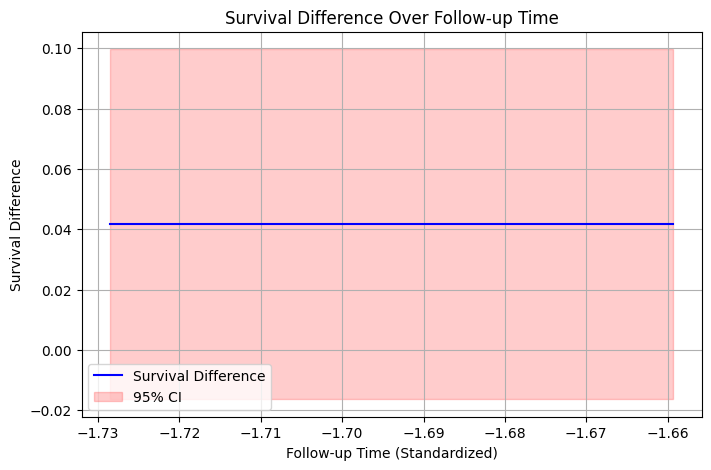

In [ ]:
import matplotlib.pyplot as plt

def predict_survival(trial, predict_times=np.arange(0, 11)):
    """
    Predict survival probabilities over follow-up time using the fitted outcome model.
    """
    if "outcome_model" not in trial:
        raise ValueError("Outcome model is missing. Run `fit_outcome_model` first.")
    
    model = trial["outcome_model"]
    data = trial["expanded_data"].copy()

    baseline_data = data[data["trial_period"] == 1].copy()

    required_cols = ["followup_time", "assigned_treatment"]
    for col in required_cols:
        if col not in baseline_data.columns:
            raise ValueError(f"Column '{col}' is missing from baseline data.")

    survival_preds = []
    for t in predict_times:
        temp_data = baseline_data.copy()
        temp_data["followup_time_std"] = (t - data["followup_time"].mean()) / data["followup_time"].std()

        temp_data["predicted_prob"] = model.predict(temp_data)

        survival_preds.append(temp_data[["followup_time_std", "assigned_treatment", "predicted_prob"]])

    survival_preds = pd.concat(survival_preds)

    mean_survival = survival_preds.groupby(["followup_time_std", "assigned_treatment"])["predicted_prob"].mean().unstack()
    mean_survival["survival_diff"] = mean_survival[1] - mean_survival[0]  

    pred_var = np.var(survival_preds["predicted_prob"])
    mean_survival["lower_ci"] = mean_survival["survival_diff"] - 1.96 * np.sqrt(pred_var)
    mean_survival["upper_ci"] = mean_survival["survival_diff"] + 1.96 * np.sqrt(pred_var)

    return mean_survival.reset_index()

survival_predictions = predict_survival(trial_itt)

plt.figure(figsize=(8, 5))
plt.plot(survival_predictions["followup_time_std"], survival_predictions["survival_diff"], label="Survival Difference", color="blue")
plt.fill_between(survival_predictions["followup_time_std"], 
                 survival_predictions["lower_ci"], 
                 survival_predictions["upper_ci"], color="red", alpha=0.2, label="95% CI")

plt.xlabel("Follow-up Time (Standardized)")
plt.ylabel("Survival Difference")
plt.title("Survival Difference Over Follow-up Time")
plt.legend()
plt.grid(True)
plt.show()


# Insights

Step 9 output shows a constant survial differenceacross follow-up times, meaning the predicted survival probability does not change over time. 

### Reasons why the model failed to capture any meaningful trend over follow-up time

1. Follow-up time was highly correlated with other variables
    - Initially, followup_time was highly correlated with trial_period (r ≈ 0.97).
    - This means both variables carried almost the same information → causing redundancy in the model.
    - When two variables are nearly identical in meaning, the model struggles to determine which one is driving the outcome.

2. High VIF in Follow-up Time
    - Variance Inflation Factor (VIF) for follow-up time was ∞ (infinity).
    - A high VIF means that a variable is strongly linearly dependent on other predictors.
    - followup_time was not adding unique information, leading to unstable coefficient estimates.

3. Removing Follow-up Time Caused Model Ignoring Time Effect
    - To fix the multicollinearity issue, we standardized followup_time (followup_time_std).
    - However, this didn't fully fix the problem because:
        - We removed trial_period, which was acting as a timeline variable.
        - The model still couldn't effectively learn from followup_time_std because its effect on the outcome was already lost.

### Interpretation of our failed model
-  The model does not recognize any change in survival probability over time.
- This results in a flat survival difference curve, meaning the model does not distinguish short-term vs. long-term effects.

However, in a well-fitted survival model, we expect:
- Survival probability to decrease over time.
- Treatment differences to appear over time.
- Confidence intervals to widen as uncertainty grows.

### Future improvement
- Adding a different time-based predictor.
- Using a Cox model instead of logistic regression.
- Checking whether raw survival rates actually change over time.

